In [1]:
!pip install -q gdown
!pip install -q umap-learn
!pip install -q --upgrade git+https://github.com/MedMNIST/MedMNIST.git
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/dataset_without_pytorch.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn
import umap
import medmnist
import dataset_without_pytorch
import time
import warnings

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn import manifold
from medmnist import INFO, Evaluator
from mlxtend.feature_selection import SequentialFeatureSelector 

matplotlib.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings("ignore")

# Задание 1. Корреляции в случайных данных

Очень классная задача.

В большом количество случайных данных почти всегда можно найти корреляции. Давайте это проверим!


1. Пусть у нас есть 5000 случайных величин $X_i$ подчиняющихся нормальному распределению $N(0,1)$. Семплируем по 40 значений для каждой из них. Для этого воспользуемся функцией np.random.normal. Должна получиться матрица с размерностью $(40 \times 5000)$. Интуитивно можно воспиримать эту матрицу как то, что мы имеем $5000$ случайных переменных, для каждой из которых мы сэмплировали по $40$ значений. Скажем, это может быть информация о записях $5000$ различных биржевых котировок за отрезок времени длиной $40$ записей.

In [3]:
from numpy.random import normal

np.random.seed(seed=42) # У нас P случайных величин и для каждой берем по N значений, так ведь? Не наоборот?
N = 40
P = 5000

x = np.random.normal(size=[N, P])

2. Разобьем полученные значения для каждой случайной величины на выборку для обучения и на тестовую в соотношении 1 к 1. У нас должны в итоге получиться две матрицы $A, B$ с размерностями $(20 \times 5000)$ и $(20 \times 5000)$.

In [4]:
#from sklearn.model_selection import train_test_split
# у нас же данные рандомные, можем просто пополам поделить, не запариваясь

print("x:",x.shape)
A=x[:][0:20]
print("A:",A.shape)
B=x[:][20:40]
print("B:",B.shape) 

x: (40, 5000)
A: (20, 5000)
B: (20, 5000)


3. Подсчитаем на основе полученных значений из матрицы $A$ матрицу корреляций для случайных величин. Должна получиться матрица $5000 \times 5000$. Используйте функцию [`np.corrcoef`](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html). Важен аргумент `rowvar`, указывающий на то, воспринимать переменные как строки или как столбцы.

In [5]:
A_Corr=np.corrcoef(A, rowvar=False)
print(A_Corr.shape)

(5000, 5000)


4. Заменим диагональные элементы матрицы корреляций на нули и найдем в полученной матрице максимальное значение. Строка $i$ и столбец $j$ соответствуют случайным величинам $X_i, X_j$, корреляция между которыми оказалась наивысшей. Отобразим значения $X_i, X_j$ на графике. Выведем значение наибольшей корреляции. 

Для выполнения этого пункта можно воспользоваться функциональностью [`np.fill_diagonal`](https://numpy.org/doc/stable/reference/generated/numpy.fill_diagonal.html) и [`np.unravel_index`](https://numpy.org/doc/stable/reference/generated/numpy.unravel_index.html).

In [6]:
for i in range(5000):
    A_Corr[i][i]=0
ind = np.unravel_index(np.argmax(A_Corr, axis=None), A_Corr.shape)
print(ind)


(1946, 3734)


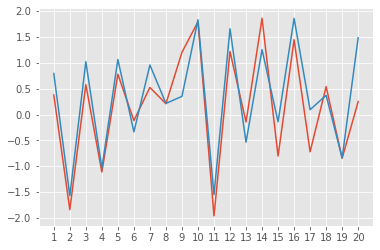

In [7]:
import matplotlib.pyplot as plt

i=ind[0]
j=ind[1]

plt.plot(range(1,21),A[:,i])
plt.plot(range(1,21),A[:,j])

plt.xticks(np.arange(1, 21, 1))


plt.show()


Фигасе, реааально сильно коррелированы!

5. Очевидно, что на самом деле никакой взаимосвязи между этими переменными нет. Давайте в этом убедимся. Для этого подсчитаем и выведем значение корреляции между $X_i$ и $X_j$ на основе данных из матрицы $B$. Будем использовать функцию [`scipy.stats.pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) (аналогична `np.corrcoef` из numpy). Отобразим значения найденных переменных $X_i$ и $X_j$ из матрицы $B$ на графике. У нас должна получиться очень маленькая (по абсолютному значению) корреляция.

In [8]:
from scipy.stats import pearsonr

res= pearsonr(B[:,i],B[:,j])
print(res[0])


-0.05719615179973292


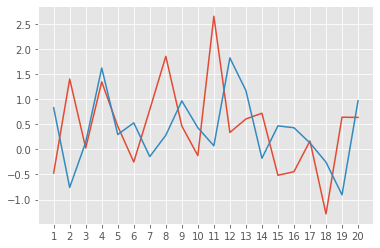

In [9]:
plt.plot(range(1,21),B[:,i])
plt.plot(range(1,21),B[:,j])

plt.xticks(np.arange(1, 21, 1))


plt.show()


# Задание 2. Методы понижения размерности

Применим методы понижения размерности: PCA, t-SNE и UMAP к изображениям клеток крови из датасета BloodMNIST. Отобразим проекцию данных на двумерное пространство, так как это допускает наиболее простую визуализацию полученного результата (воспользуемся [`sns.scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)).  Глянем, какой метод позволяет лучше разделить данные в пространстве. 

Загрузка данных:

In [10]:
data_flag = 'bloodmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
bloodmnist = DataClass(split='train', download=download)
print(bloodmnist)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 4.0


Доступ к данным идет посредством обращения к ключу `bloodmnist.imgs`, доступ к разметке классов -- через `bloodmnist.labels`

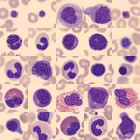

In [11]:
x = bloodmnist.imgs / 255.
x = x.reshape(-1, 2352)
y = pd.Series(bloodmnist.labels.reshape(-1))
y = y.astype('int').map(dict(zip(range(0, 8), info['label'].values())))

 
bloodmnist.montage(length=5)

## PCA

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)


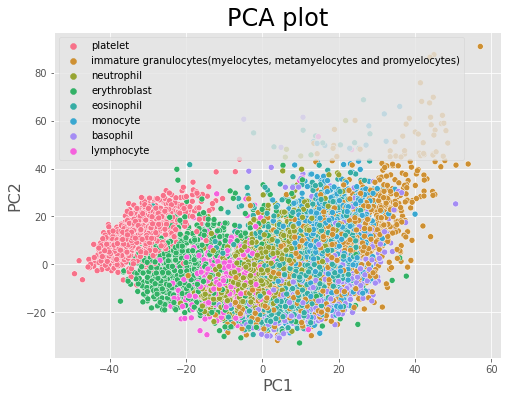

In [13]:
from sklearn.decomposition import PCA
from seaborn import scatterplot

our_pca = sklearn.decomposition.PCA(n_components=2)
our_pca.fit(x)
x_reduced = our_pca.transform(x)



plt.figure(figsize=(8, 6))
plt.title('PCA plot', size=24)
plt.xlabel('PC1', size=16)
plt.ylabel('PC2', size=16)
sns.scatterplot(x=x_reduced[:, 0],
                y=x_reduced[:, 1], 
                hue=y);


In [14]:
print(type(x),type(y))
y

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


0                                                 platelet
1        immature granulocytes(myelocytes, metamyelocyt...
2                                               neutrophil
3                                               neutrophil
4                                                 platelet
                               ...                        
11954                                           neutrophil
11955                                         erythroblast
11956                                           eosinophil
11957                                           neutrophil
11958                                           lymphocyte
Length: 11959, dtype: object

In [15]:
#y=y.to_numpy()

In [16]:
type(y)
y[5]


'neutrophil'

## t-SNE

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.028s...
[t-SNE] Computed neighbors for 11959 samples in 0.481s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 0.886191
[t-SNE] Computed con

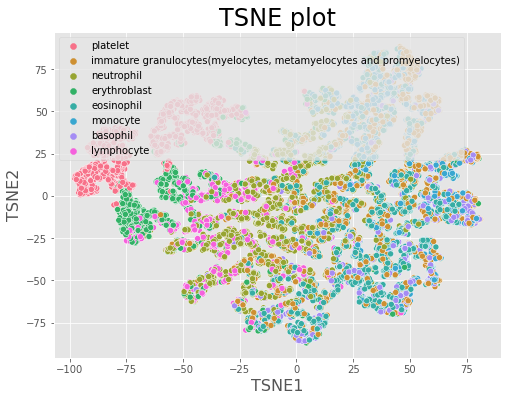

In [17]:
import sklearn.manifold

# стартую с того результата PCA, который замутил в самом начале

model = sklearn.manifold.TSNE(n_components=2, 
             init = x_reduced, 
             perplexity=40,
             verbose=2,
             learning_rate='auto')

manifold = model.fit_transform(x_reduced)



plt.figure(figsize=(8, 6))
plt.title('TSNE plot', size=24)
plt.xlabel('TSNE1', size=16)
plt.ylabel('TSNE2', size=16)
sns.scatterplot(x=manifold[:, 0],
                y=manifold[:, 1], 
                hue=y);

#plt.figure(figsize = (10, 5))
#plt.scatter(manifold[:, 0], manifold[:, 1], c=y, cmap='tab20', s=20)
#plt.title('TSNE', fontsize=25); 
#plt.xlabel("TSNE1", fontsize=22)
#plt.ylabel("TSNE2", fontsize=22)
#plt.show()

## UMAP

UMAP(init=array([[-35.67641029, 18.31627267],
       [ 30.19194904, 18.83256339],
       [-10.75335471, -10.91494422],
       ...,
       [ 10.97017241, -20.13948049],
       [  6.24290672, 5.98614196],
       [-10.18381201, -6.77882358]]), min_dist=1, n_epochs=1000, n_neighbors=93, verbose=2)
Sun Jan 15 15:55:34 2023 Construct fuzzy simplicial set
Sun Jan 15 15:55:34 2023 Finding Nearest Neighbors
Sun Jan 15 15:55:34 2023 Building RP forest with 10 trees
Sun Jan 15 15:55:39 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	Stopping threshold met -- exiting after 2 iterations
Sun Jan 15 15:56:07 2023 Finished Nearest Neighbor Search
Sun Jan 15 15:56:10 2023 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

Sun Jan 15 15:57:33 2023 Finished embedding


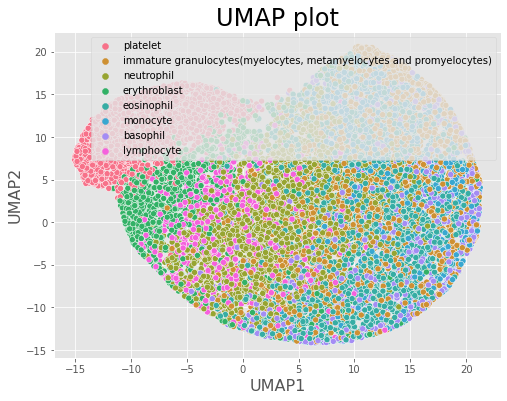

In [18]:
from umap import UMAP

# стартую с того результата PCA, который замутил в самом начале

model = UMAP(n_components=2, 
             min_dist=1, 
             n_neighbors=93,
             init=x_reduced, 
             n_epochs=1000, 
             verbose=2)

umap = model.fit_transform(x_reduced)

plt.figure(figsize=(8, 6))
plt.title('UMAP plot', size=24)
plt.xlabel('UMAP1', size=16)
plt.ylabel('UMAP2', size=16)
sns.scatterplot(x=umap[:, 0],
                y=umap[:, 1], 
                hue=y);

#clear_output()
#plt.figure(figsize = (10, 5))
#plt.scatter(umap[:, 0], umap[:, 1], c=y, cmap='tab20', s=20)
#plt.title('UMAP', fontsize=25); 
#plt.xlabel("UMAP1", fontsize=22)
#plt.ylabel("UMAP2", fontsize=22)
#plt.show()

Тбх, все работает не очень. Может, датасет слишком сложный и даже в бóльших размерностях его особо не разбить на кластеры.

# Задание 3. Feature selection и feature engineering

В этом задании, используя датасет с [данными о здоровье плода](https://www.kaggle.com/andrewmvd/fetal-health-classification), сравним различные подходы к отбору признаков. Загрузим датасет:

In [19]:
data = pd.read_csv("https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX04/fetal_health.csv")
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


Посмотрим на данные. Видно, что среди представленных признаков довольно много скоррелированных:

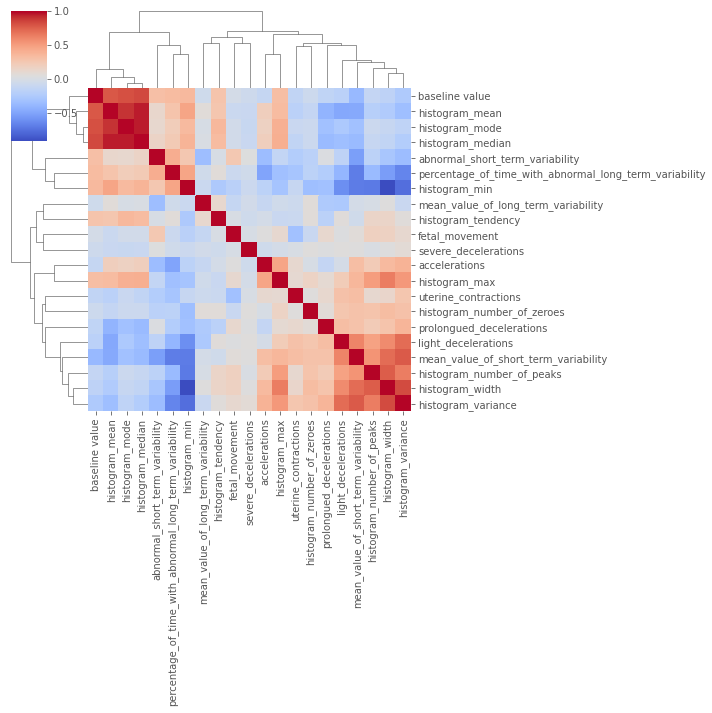

In [20]:
x = data.drop('fetal_health', axis=1)
x = pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns, index= x.index)
y = data['fetal_health']

corr_matrix = x.corr(method='spearman')
res = sns.clustermap(corr_matrix, method='weighted', figsize=(10, 10), cmap='coolwarm')

Используя жадный отбор признаков, Add Del и PCA, отберем/сгенерируем от 1 до 20 признаков и сравним на кросс-валидации `accuracy` для моделей `RandomForestClassifier(n_estimators=50, random_state=42)` из `sklearn.ensemble`, получающихся в процессе отбора/генерации признаков. Сравним полученные результаты с `accuracy` модели, обученной с использованием всех имеющихся признаков (на кросс-валидации с тем же количеством фолдов). Изобразим результаты в виде графика, опишем свои наблюдения.

In [21]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [22]:
# Жадный отбор признаков
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.ensemble import RandomForestClassifier

sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=50, random_state=42),
                                k_features=(1,20), # меня смущает отсутствие этого параметра в документации
                                cv= KFold(n_splits=4,shuffle=True)) # правильно же шаффлю здесь? 

sfs.fit(x, y)

SequentialFeatureSelector(cv=KFold(n_splits=4, random_state=None, shuffle=True),
                          estimator=RandomForestClassifier(n_estimators=50,
                                                           random_state=42),
                          k_features=(1, 20))

In [23]:
df1 = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
df1.head(5)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[0.849624060150376, 0.8270676691729323, 0.8229...",0.825953,"(mean_value_of_short_term_variability,)",0.025923,0.016172,0.009337
2,"(6, 8)","[0.8439849624060151, 0.868421052631579, 0.8813...",0.860305,"(prolongued_decelerations, mean_value_of_short...",0.024579,0.015333,0.008853
3,"(6, 8, 9)","[0.8778195488721805, 0.8571428571428571, 0.877...",0.86971,"(prolongued_decelerations, mean_value_of_short...",0.013824,0.008624,0.004979
4,"(6, 7, 8, 9)","[0.9172932330827067, 0.9097744360902256, 0.903...",0.911569,"(prolongued_decelerations, abnormal_short_term...",0.008312,0.005185,0.002994
5,"(6, 7, 8, 9, 16)","[0.9323308270676691, 0.9360902255639098, 0.934...",0.936503,"(prolongued_decelerations, abnormal_short_term...",0.00682,0.004255,0.002457


In [24]:
# Теперь Add Del

sffs = SequentialFeatureSelector(
           RandomForestClassifier(n_estimators=50, random_state=42),
           k_features=(1,20), 
           forward=True, # какой именно параметр здесь отвечает за то, что это уже Add Del?
           floating=True,
           verbose=0,
           scoring='accuracy',
           cv=KFold(n_splits=4,shuffle=True)) 

sffs.fit(x.values, y)
df2 = pd.DataFrame.from_dict(sffs.get_metric_dict()).T
df2.head(5)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[0.8345864661654135, 0.8157894736842105, 0.819...",0.825023,"(8,)",0.012432,0.007756,0.004478
2,"(6, 8)","[0.8477443609022557, 0.8571428571428571, 0.871...",0.857484,"(6, 8)",0.014407,0.008987,0.005189
3,"(6, 7, 8)","[0.8721804511278195, 0.8552631578947368, 0.902...",0.878189,"(6, 7, 8)",0.027269,0.017012,0.009822
4,"(6, 7, 8, 9)","[0.9116541353383458, 0.9060150375939849, 0.919...",0.911574,"(6, 7, 8, 9)",0.007614,0.00475,0.002742
5,"(6, 7, 8, 9, 16)","[0.9266917293233082, 0.943609022556391, 0.9378...",0.93556,"(6, 7, 8, 9, 16)",0.009844,0.006141,0.003546


In [25]:
# Теперь просто модель, обученная на данных со всеми признаками

kf = KFold(n_splits=4,shuffle=True)
res=0
for train_index, test_index in kf.split(x):
    X_train, X_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    res+=accuracy_score(y_test, model.predict(X_test))/4
print("Средняя accuracy на фолдах:",res)

Средняя accuracy на фолдах: 0.9426169590643274


In [26]:
# теперь PCA
# Сначала вроде как нужно нормализовать данные, райт?
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(x)


In [27]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

acc=[]
for i in range(1, 21):
  our_pca = sklearn.decomposition.PCA(n_components=i) # вообще, можно просто брать слайсы, но лень заново обучать
  our_pca.fit(x)
  x_reduced = our_pca.transform(x)

  kf = KFold(n_splits=4,shuffle=True)
  summ=[]
  for train_index, test_index in kf.split(x_reduced):
      X_train, X_test = x_reduced[train_index], x_reduced[test_index]
      y_train, y_test = y[train_index], y[test_index]
      model = RandomForestClassifier(n_estimators=50, random_state=42)
      model.fit(X_train, y_train)
      summ.append(accuracy_score(y_test, model.predict(X_test)))
  temp=sum(summ)/4
  acc.append(temp)
  print("Кол-во признаков:",i,"||| Средняя accuracy на фолдах:",temp)


Кол-во признаков: 1 ||| Средняя accuracy на фолдах: 0.7474220508899367
Кол-во признаков: 2 ||| Средняя accuracy на фолдах: 0.8593597340809651
Кол-во признаков: 3 ||| Средняя accuracy на фолдах: 0.8932376846069977
Кол-во признаков: 4 ||| Средняя accuracy на фолдах: 0.8936961046684507
Кол-во признаков: 5 ||| Средняя accuracy на фолдах: 0.8984006626736333
Кол-во признаков: 6 ||| Средняя accuracy на фолдах: 0.897930737861603
Кол-во признаков: 7 ||| Средняя accuracy на фолдах: 0.9059221146085552
Кол-во признаков: 8 ||| Средняя accuracy на фолдах: 0.9021574062274329
Кол-во признаков: 9 ||| Средняя accuracy на фолдах: 0.8969882332951021
Кол-во признаков: 10 ||| Средняя accuracy на фолдах: 0.905473429336052
Кол-во признаков: 11 ||| Средняя accuracy на фолдах: 0.9054566147005934
Кол-во признаков: 12 ||| Средняя accuracy на фолдах: 0.907793849029353
Кол-во признаков: 13 ||| Средняя accuracy на фолдах: 0.9054468799116435
Кол-во признаков: 14 ||| Средняя accuracy на фолдах: 0.9087513982696855
Кол-

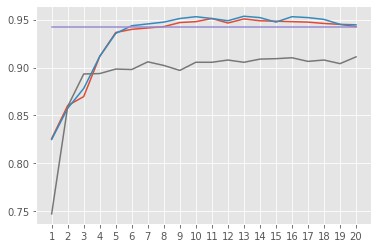

In [28]:
import matplotlib.pylab as plt # не оч умею рисовать чем-то другим

d=sfs.get_metric_dict()
lists = sorted(d.items()) 
x, y = zip(*lists) 
y=[t["avg_score"] for t in y]
plt.plot(x, y)

d=sffs.get_metric_dict()
lists = sorted(d.items()) 
x, y = zip(*lists)
y=[t["avg_score"] for t in y]
plt.plot(x, y)

plt.plot(range(1,21),[res]*20)

plt.plot(range(1,21),acc)

plt.xticks(np.arange(1, 21, 1))


plt.show()

# Задание 4. Использование понижения размерности для ускорения обучения

Рассмотрим набор данных TissueMNIST. В этом задании мне нужно сравнить производительность двух моделей: обученной с использованием всех доступных признаков и обученной на данных пониженной размерности. От меня требуется:

1. Посторить модель `RandomForestClassifier()` и обучить ее на тренировочной выборке, оценить `accuracy` модели на тестовой выборке и время, потраченное на обучение;
2. Построить модель PCA на тренировочных данных и определить число главных компонент, объясняющих 90% дисперсии;
3. Спроецировать данные тестовой выборки на главные компоненты полученной модели PCA;
4. Построить модель `RandomForestClassifier()` и обучить ее на данных пониженной размерности, оценить `accuracy` модели на тестовой выборке и время, потраченное на обучение.

In [29]:
data_flag = 'tissuemnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(dataset_without_pytorch, info['python_class'])

# load the data
tissuemnist = DataClass(split='test', download=download)
print(tissuemnist)

  0%|          | 0/124962739 [00:00<?, ?it/s]

Dataset TissueMNIST (tissuemnist)
    Number of datapoints: 47280
    Root location: /root/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'Collecting Duct, Connecting Tubule', '1': 'Distal Convoluted Tubule', '2': 'Glomerular endothelial cells', '3': 'Interstitial endothelial cells', '4': 'Leukocytes', '5': 'Podocytes', '6': 'Proximal Tubule Segments', '7': 'Thick Ascending Limb'}
    Number of samples: {'train': 165466, 'val': 23640, 'test': 47280}
    Description: We use the BBBC051, available from the Broad Bioimage Benchmark Collection. The dataset contains 236,386 human kidney cortex cells, segmented from 3 reference tissue specimens and organized into 8 categories. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. Each gray-scale image is 32×32×7 pixels, where 7 denotes 7 slices. We take maximum values across the slices and resize them into 28×28 gray-scale images.
    License: CC BY 4

In [30]:
x = tissuemnist.imgs / 255.
x = x.reshape(-1, 784)
y = tissuemnist.labels
 
tissuemnist.montage(length=5)

x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.2)

In [31]:
rng = np.random.RandomState(42)
rf = RandomForestClassifier(n_estimators=200, random_state=rng)

from sklearn.metrics import accuracy_score
import time
start = time.time()
rf.fit(x_train,y_train)
end = time.time()
print("WITHOUT PCA")
print("Accuracy: ", accuracy_score(y_true=y_test, y_pred=rf.predict(x_test)))
print("Learning time: ", end-start)

WITHOUT PCA
Accuracy:  0.5232656514382402
Learning time:  172.1316020488739


In [32]:
x_train.shape

(37824, 784)

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#pca = PCA(n_components=x_train.shape[1])
#pca.fit(x_train)

#ths = 0.90
#total_explained = np.cumsum(pca.explained_variance_ratio_)
#chosen_number = np.where(total_explained >= 0.95)[0][0] + 1
#print("90 процентов дисперсии обьясняют",chosen_number,"выделенных фичей из", x_train.shape[1])

pca = PCA(n_components = 0.9, svd_solver = 'full')
pca.fit(x_train)
x_train_reduced = pca.transform(x_train)
x_test_reduced = pca.transform(x_test)

In [34]:
print("90 процентов дисперсии обьясняют",x_train_reduced.shape[1],"выделенных фичей из", x_train.shape[1])

90 процентов дисперсии обьясняют 59 выделенных фичей из 784


In [35]:
rf_red = RandomForestClassifier(n_estimators=200, random_state=rng)
start = time.time()
rf_red.fit(x_train_reduced,y_train)
end = time.time()
print("WITH PCA")
print("Accuracy: ", accuracy_score(y_true=y_test, y_pred=rf_red.predict(x_test_reduced)))
print("Learning time: ", end-start)

WITH PCA
Accuracy:  0.49323181049069376
Learning time:  88.01205134391785


_Вывод:_

Мы спроецировали данные на 58 компонент главных компонент, т.е. получили 58 важных фичей (обьясняющих 90% дисперсии) вместо 784. Это дало нам очень маленькое ухудшение качества (<3%), но ускорило обучение примерно в 2 раза (теперь оно заняло 74 секунды вместо 146).
